Plotting the C_free region of 2D configurations from training data.


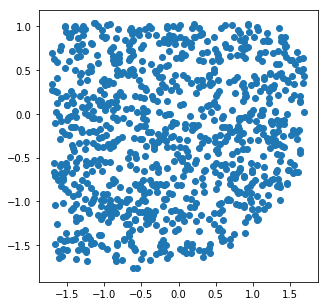

Plotting the C_free region of a 2D configurations from test data:


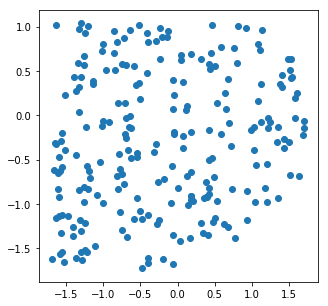

The shape of C_free_X in training is: (940, 2)
The shape of C_free_y in training is: (940,)
The shape of C_free_X in test is: (231, 2)
The shape of C_free_y in test is: (231,)


In [1]:
# Load data into jupyter
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from torch.utils.data import DataLoader

a
data_file_name = "./right_joint_states/right_2_1443_1548622626.03.csv"

def load_csv_file(filename, skiprows = 0):
  return np.loadtxt(open(filename, "rb"), delimiter=",", skiprows = skiprows)

def plot_configuration(config):
  """
  Scatter-plot the 2D array and return the figure;
  :param config: a n x 2 tensor/ndarray 
  """
  figure = plt.figure(figsize = (5,5))
  plt.scatter(config[:,0], config[:,1])
  plt.show()
  return figure

data = load_csv_file(data_file_name, 1)
np.random.shuffle(data)
cutoff = math.ceil(data.shape[0] * 0.8) # 80 percent training data
train_data = data[:cutoff, :]
test_data = data[cutoff:, :]

train_X = train_data[:, :2] # Extract only the first two columns;
train_y = train_data[:, -1]

train_free_y = train_y[train_y == 1]
train_free_X = train_X[train_y == 1]
# train_collision_y = train_y[train_y == 1]
# train_collision_X = train_X[train_y == 1]

test_X = test_data[:, :2]
test_y = test_data[:, -1]
test_free_X = test_X[test_y == 1]
test_free_y = test_y[test_y == 1]
# test_collision_X = test_X[test_y == 1]
# test_collision_y = test_y[test_y == 1]

# Plot the training input 
print("Plotting the C_free region of 2D configurations from training data.")
plot_configuration(train_free_X)
# print("Plotting the C_collision region of 2D configurations from training data.")
# plot_configuration(train_collision_X)


# Plot the test input 
print("Plotting the C_free region of a 2D configurations from test data:")
plot_configuration(test_free_X)

# print("Plotting the C_collision region of a 2D configurations from test data:")
# plot_configuration(test_collision_X)


print("The shape of C_free_X in training is: %s" % (train_free_X.shape, ))
print("The shape of C_free_y in training is: %s" % (train_free_y.shape, ))

print("The shape of C_free_X in test is: %s" % (test_free_X.shape, ))
print("The shape of C_free_y in test is: %s" % (test_free_y.shape, ))

train_loader = DataLoader(train_free_X, batch_size=batch_size,
                        shuffle=True, num_workers=1)
test_loader = DataLoader(test_free_X, batch_size=batch_size, shuffle=True, num_workers=1)

# print("The shape of C_collision_X in training is: %s" % (train_collision_X.shape, ))
# print("The shape of C_collision_y in training is: %s" % (train_collision_y.shape, ))

# print("The shape of C_collision_X in test is: %s" % (test_collision_X.shape, ))
# print("The shape of C_collision_y in test is: %s" % (test_collision_y.shape, ))

# train_loader = DataLoader(train_collision_X, batch_size=batch_size,
#                         shuffle=True, num_workers=1)
# test_loader = DataLoader(test_collision_X, batch_size=batch_size, shuffle=True, num_workers=1)

In [2]:
# VAE model definition. Adapted from: https://github.com/pytorch/examples/blob/master/vae/main.py
import torch
import torch.nn
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    
    # Simple 2-layer network to tranform a 2-dimensional vector into a scalar;
    def __init__(self):
        super(VAE, self).__init__()
        # The latent variable is defined as z = N(\mu, \logvar).
        self.fc1 = nn.Linear(D_input, D_H)
        self.mean = nn.Linear(D_H, D_output)
        self.logvar = nn.Linear(D_H, D_output)
        
        self.fc2 = nn.Linear(D_output, D_H)
        self.fc3 = nn.Linear(D_H, D_input)

    # Encode the input into a normal distribution
    def encode(self, x):
        # Apply function to obtain the mean and variance
        hidden_output = F.sigmoid(self.fc1(x))
        return self.mean(hidden_output), self.logvar(hidden_output)

    # Reparametrize the normal;
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # Adding stochasticity in the process;
        eps = torch.randn_like(std)
        
        # print("z is: %s" %  eps.mul(std).add_(mu))
        return eps.mul(std).add_(mu)
    

    def decode(self, z):
        return F.sigmoid(self.fc3(F.sigmoid(self.fc2(z))))

    # Forward pass; 
    def forward(self, x):
        # Change the array to float first;
        mu, logvar = self.encode(x.view(-1, 2))
        # print("The value of mu and logvars are: %s, %s" % (mu, logvar))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    loss = nn.MSELoss(reduction ='sum')
    BCE = loss(recon_x, x.view(-1, 2))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        print("The shape of the data is: %s" % (data.shape,) )
        data = data.to(device).float()
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch, batch_idx * len(data), len(train_loader.dataset),
#             100. * batch_idx / len(train_loader),
#             loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return mu, logvar

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device).float()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

The shape of the data is: torch.Size([940, 2])
====> Epoch: 1 Average loss: 2.4641


/Users/jamesdi/Programs/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


====> Test set loss: 2.7003
Plotting samples in the 1 epoch.


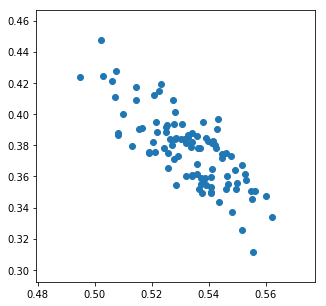

The shape of the data is: torch.Size([940, 2])
====> Epoch: 2 Average loss: 2.4481
====> Test set loss: 2.6874
Plotting samples in the 2 epoch.


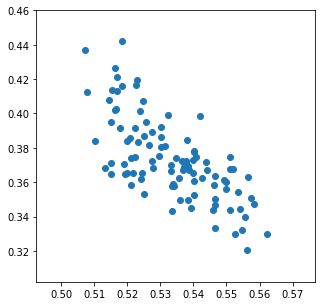

The shape of the data is: torch.Size([940, 2])
====> Epoch: 3 Average loss: 2.4418
====> Test set loss: 2.6806
Plotting samples in the 3 epoch.


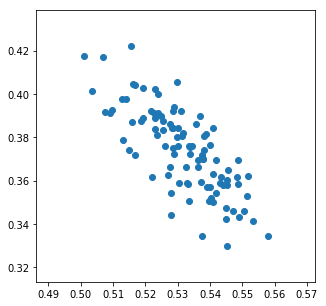

The shape of the data is: torch.Size([940, 2])
====> Epoch: 4 Average loss: 2.4343
====> Test set loss: 2.6686
Plotting samples in the 4 epoch.


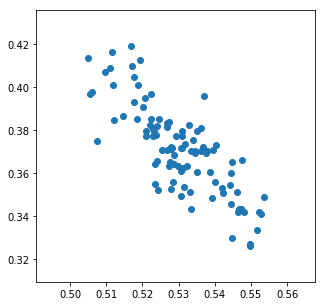

The shape of the data is: torch.Size([940, 2])
====> Epoch: 5 Average loss: 2.4262
====> Test set loss: 2.6595
Plotting samples in the 5 epoch.


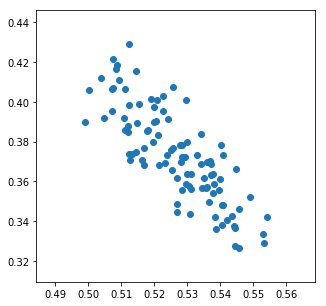

The shape of the data is: torch.Size([940, 2])
====> Epoch: 6 Average loss: 2.4165
====> Test set loss: 2.6537
Plotting samples in the 6 epoch.


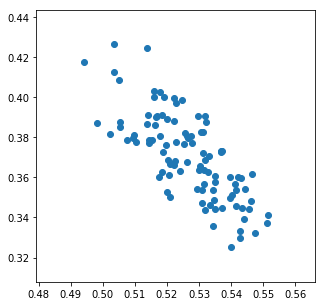

The shape of the data is: torch.Size([940, 2])
====> Epoch: 7 Average loss: 2.4109
====> Test set loss: 2.6416
Plotting samples in the 7 epoch.


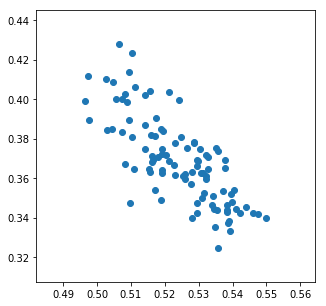

The shape of the data is: torch.Size([940, 2])
====> Epoch: 8 Average loss: 2.4016
====> Test set loss: 2.6387
Plotting samples in the 8 epoch.


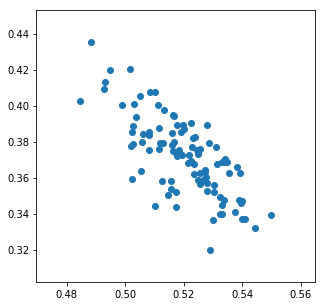

The shape of the data is: torch.Size([940, 2])
====> Epoch: 9 Average loss: 2.3927
====> Test set loss: 2.6223
Plotting samples in the 9 epoch.


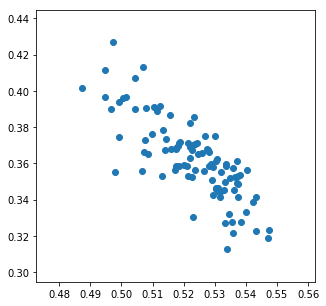

The shape of the data is: torch.Size([940, 2])
====> Epoch: 10 Average loss: 2.3828
====> Test set loss: 2.6149
Plotting samples in the 10 epoch.


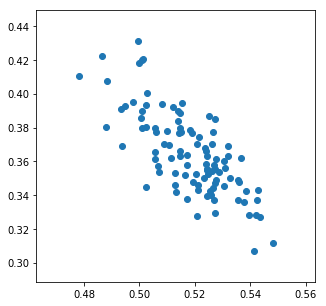

The shape of the data is: torch.Size([940, 2])
====> Epoch: 11 Average loss: 2.3742
====> Test set loss: 2.6128
Plotting samples in the 11 epoch.


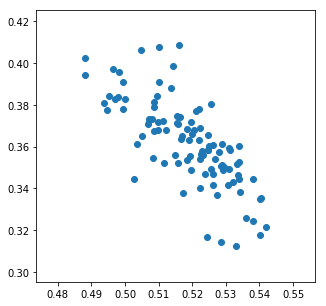

The shape of the data is: torch.Size([940, 2])
====> Epoch: 12 Average loss: 2.3649
====> Test set loss: 2.5999
Plotting samples in the 12 epoch.


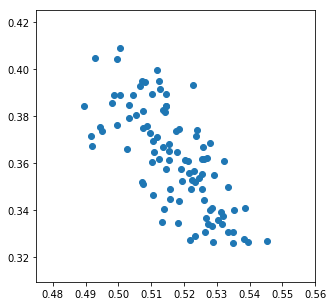

The shape of the data is: torch.Size([940, 2])
====> Epoch: 13 Average loss: 2.3572
====> Test set loss: 2.5951
Plotting samples in the 13 epoch.


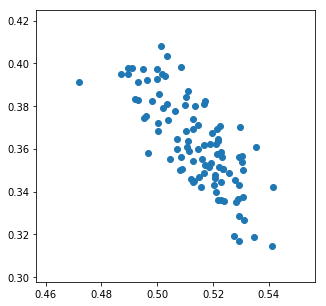

The shape of the data is: torch.Size([940, 2])
====> Epoch: 14 Average loss: 2.3493
====> Test set loss: 2.5879
Plotting samples in the 14 epoch.


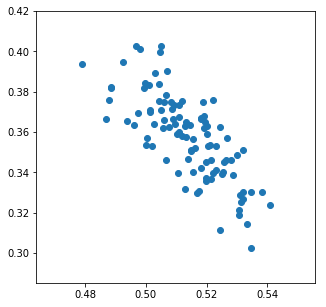

The shape of the data is: torch.Size([940, 2])
====> Epoch: 15 Average loss: 2.3439
====> Test set loss: 2.5734
Plotting samples in the 15 epoch.


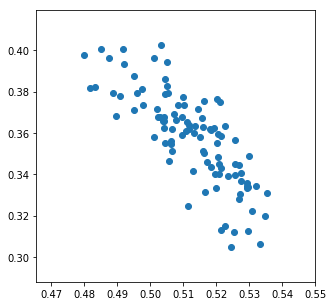

The shape of the data is: torch.Size([940, 2])
====> Epoch: 16 Average loss: 2.3351
====> Test set loss: 2.5639
Plotting samples in the 16 epoch.


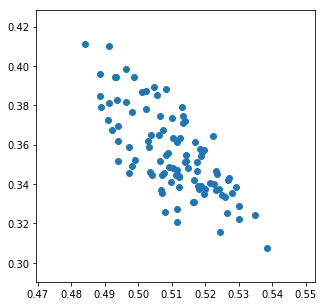

The shape of the data is: torch.Size([940, 2])
====> Epoch: 17 Average loss: 2.3272
====> Test set loss: 2.5631
Plotting samples in the 17 epoch.


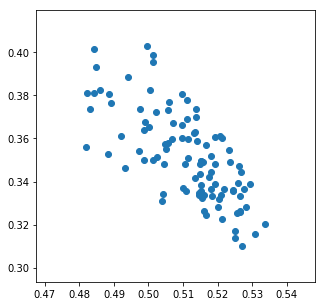

The shape of the data is: torch.Size([940, 2])
====> Epoch: 18 Average loss: 2.3208
====> Test set loss: 2.5553
Plotting samples in the 18 epoch.


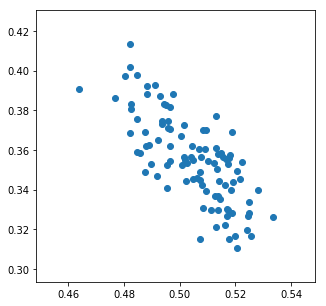

The shape of the data is: torch.Size([940, 2])
====> Epoch: 19 Average loss: 2.3141
====> Test set loss: 2.5510
Plotting samples in the 19 epoch.


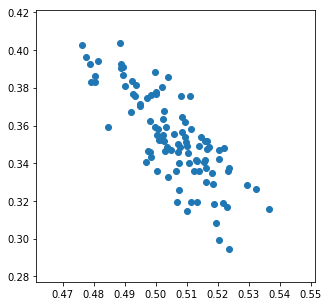

The shape of the data is: torch.Size([940, 2])
====> Epoch: 20 Average loss: 2.3078
====> Test set loss: 2.5441
Plotting samples in the 20 epoch.


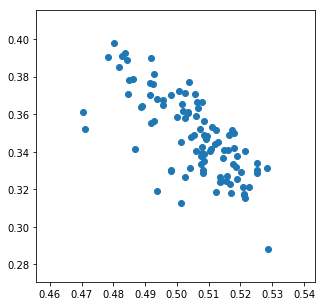

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

# Train and execute;
epochs = 20
generated_batch_size = 100

sample_array = None
for epoch in range(1, epochs + 1):
    mu, logvar = train(epoch)
    test(epoch)
    with torch.no_grad():
        # Sample a hundred normals
        norms = torch.randn(generated_batch_size, 2).to(device)
        # samples = model.generate(norms, mu, logvar)
        samples = model.decode(norms).cpu()
        samples = samples.view(generated_batch_size, 2)
        
        print("Plotting samples in the %d epoch." % (epoch,))
        plot_configuration(samples)

/Users/jamesdi/Programs/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


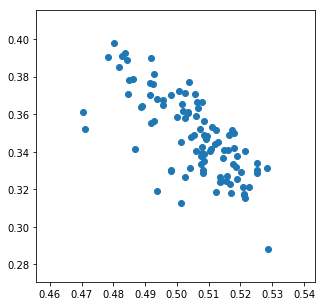

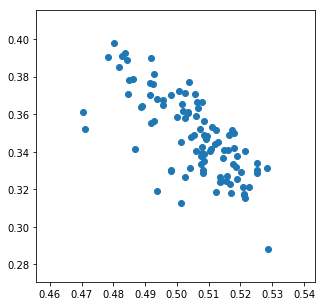

In [4]:
mean, logvar = model.encode(torch.from_numpy(train_free_X).float())
z = model.reparameterize(mean, logvar)
reconstructed_samples = model.decode(z).cpu()
reconstructed_samples = samples.view(-1, 2)

# Plotting the reconstructed configurations from training data. 
plot_configuration(reconstructed_samples)